In [141]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, plot_roc_curve

## Data reading and preprocessing

In [142]:
# is there any Nan values
train = pd.read_csv('../input/advanced-dls-fall-2020/train.csv')
test = pd.read_csv('../input/advanced-dls-fall-2020/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [144]:
# finding binary categorical features
is_binary = []
for col in train[categorical].columns:
    if len(train[col].value_counts()) == 2:
        is_binary.append(col)

In [145]:
is_binary

['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'IsBillingPaperless']

In [146]:
# value count for target 
train.Churn.value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

Классы не сбалансированы, требуется балансировка

In [147]:
categorical = ['Sex','HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
numeric = [c for c in train.columns if c not in categorical]

In [148]:
# removal of duplicate columns for binary features
# train
to_drop =['Sex_Male'] +  [c + '_No' for c in is_binary[1:]]
encoded_categorical = pd.get_dummies(train[categorical])
encoded_categorical.drop(columns = to_drop, inplace = True)

In [149]:
# removal of duplicate columns for binary features
# test
test_encoded_categorical = pd.get_dummies(test[categorical])
test_encoded_categorical.drop(columns = to_drop, inplace = True)

In [150]:
train_preprocessed = encoded_categorical.merge(train[numeric],left_index=True, right_index=True)
train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Sex_Female                                    5282 non-null   uint8  
 1   HasPartner_Yes                                5282 non-null   uint8  
 2   HasChild_Yes                                  5282 non-null   uint8  
 3   HasPhoneService_Yes                           5282 non-null   uint8  
 4   HasMultiplePhoneNumbers_No                    5282 non-null   uint8  
 5   HasMultiplePhoneNumbers_No phone service      5282 non-null   uint8  
 6   HasMultiplePhoneNumbers_Yes                   5282 non-null   uint8  
 7   HasInternetService_DSL                        5282 non-null   uint8  
 8   HasInternetService_Fiber optic                5282 non-null   uint8  
 9   HasInternetService_No                         5282 non-null   u

In [151]:
test_preprocessed = test_encoded_categorical.merge(train[numeric[:-1]],left_index=True, right_index=True)
test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 0 to 1760
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Sex_Female                                    1761 non-null   uint8  
 1   HasPartner_Yes                                1761 non-null   uint8  
 2   HasChild_Yes                                  1761 non-null   uint8  
 3   HasPhoneService_Yes                           1761 non-null   uint8  
 4   HasMultiplePhoneNumbers_No                    1761 non-null   uint8  
 5   HasMultiplePhoneNumbers_No phone service      1761 non-null   uint8  
 6   HasMultiplePhoneNumbers_Yes                   1761 non-null   uint8  
 7   HasInternetService_DSL                        1761 non-null   uint8  
 8   HasInternetService_Fiber optic                1761 non-null   uint8  
 9   HasInternetService_No                         1761 non-null   u

'TotalSpent' column has string type, lets fix it

In [152]:
#Train
train_preprocessed.TotalSpent = pd.to_numeric(X['TotalSpent'],errors='coerce')
train_preprocessed.dropna(inplace = True)
X = train_preprocessed.iloc[:,:-1]
y = train_preprocessed.iloc[:,-1]

In [153]:
#Test
test_preprocessed.TotalSpent = pd.to_numeric(test_preprocessed['TotalSpent'],errors='coerce')
test_preprocessed.TotalSpent.fillna(test_preprocessed.TotalSpent.mean(), inplace = True)


In [154]:
test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 0 to 1760
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Sex_Female                                    1761 non-null   uint8  
 1   HasPartner_Yes                                1761 non-null   uint8  
 2   HasChild_Yes                                  1761 non-null   uint8  
 3   HasPhoneService_Yes                           1761 non-null   uint8  
 4   HasMultiplePhoneNumbers_No                    1761 non-null   uint8  
 5   HasMultiplePhoneNumbers_No phone service      1761 non-null   uint8  
 6   HasMultiplePhoneNumbers_Yes                   1761 non-null   uint8  
 7   HasInternetService_DSL                        1761 non-null   uint8  
 8   HasInternetService_Fiber optic                1761 non-null   uint8  
 9   HasInternetService_No                         1761 non-null   u

'TotalSpent' is ok

## balancing unbalanced classes

In [155]:
# Балансировка классов для улучшения работы классификатора
from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X,y)
X_resampled, y_resampled = ros.fit_sample(X, y)
print('Количество элементов до операции:', len(X))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 5273
Количество элементов после операции: 7778


In [156]:
y_resampled.value_counts()

1    3889
0    3889
Name: Churn, dtype: int64

## Train RF model

In [157]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 77)

In [169]:
RFC = RandomForestClassifier(n_estimators = 1000, min_samples_leaf = 8)
RFC.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=1000)

## Validation 

In [170]:
RFC.score(X_test,y_test)

0.8438303341902313

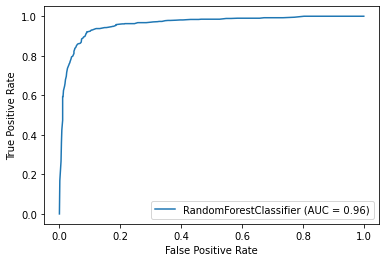

In [160]:
plot_roc_curve(RFC,X_test,y_test);

## Predictions

Train on full test data

In [171]:
RFC.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=4, n_estimators=1000)

In [162]:
submission_sample = pd.read_csv('../input/advanced-dls-fall-2020/submission.csv')
submission_sample.head()

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [172]:
predictions = RFC.predict_proba(test_preprocessed)[:,1]

In [165]:
predictions

array([0.2 , 0.43, 1.  , ..., 0.55, 0.5 , 0.04])

In [174]:
submission = submission_sample.copy()
submission['Churn'] = predictions
submission.to_csv('submit.csv',index=False)